In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy import ndimage

In [166]:
bav = pd.read_csv("../../data/processed/stops_with_data.csv")
# delet cols
bav.drop(columns=[
    "x_fa2", 
    "y_fa2",
    "indegree",
    "outdegree",
    "degree",
    "betweenness_centrality",
], inplace=True)
bav.rename(columns={
    "x_geo": "x",
    "y_geo": "y",
}, inplace=True)
bav.head()

,id,label,x,y,transport_type,city,canton,is_bus_stop,is_tram_stop,is_train_stop,is_metro_stop,is_rack_railway_stop,is_boat_stop
0,8500010,Basel SBB,8747.787053,1083.724166,Train,Basel,BS,False,False,True,False,False,False
1,8500016,Basel St. Johann,8740.453774,1098.214087,Train,Basel,BS,False,False,True,False,False,False
2,8500020,Muttenz,8772.829603,1075.023376,Train,Muttenz,BL,False,False,True,False,False,False
3,8500021,Pratteln,8791.268213,1068.157330,Train,Pratteln,BL,False,False,True,False,False,False
4,8500023,Liestal,8808.760961,1044.015059,Train,Liestal,BL,False,False,True,False,False,False


In [182]:
class Heatmap:
    def __init__(self, df, resolution = 1000, margin = 10):
        self.df = df
        self.resolution = resolution
        self.margin = margin

        self.df = self.set_coordinates()

    def set_coordinates(self):
        min_x = self.df['x'].min()
        max_x = self.df['x'].max()
        min_y = self.df['y'].min()
        max_y = self.df['y'].max()

        lon_scale = self.resolution / (max_x - min_x)
        lat_scale = self.resolution / (max_y - min_y)
        scale = min(lat_scale, lon_scale)

        self.df['x_con'] = (self.df['x'] - min_x) * scale
        self.df['y_con'] = (self.df['y'] - min_y) * scale
        self.df['x_dis'] = self.df['x_con'].astype(int)
        self.df['y_dis'] = self.df['y_con'].astype(int)

        self.width = int((max_x - min_x) * scale)
        self.height = int((max_y - min_y) * scale)

        return self.df

    def get_df(self):
        return self.df
    
    def get_density_heatmap(self, radius=10):
        density = np.zeros((self.width + 2 * self.margin + 1, self.height + 2 * self.margin + 1))

        for _, row in self.df.iterrows():
            x = int(row['x_dis']) + self.margin
            y = int(row['y_dis']) + self.margin
            density[x, y] += 1

        # Apply a Gaussian filter to compute the densities
        density_filtered = ndimage.gaussian_filter(density, sigma=radius)

        return density_filtered
    
    def get_density_heatmap_for_transport_type(self, transport_type, radius=10):
        density = np.zeros((self.width + 2 * self.margin + 1, self.height + 2 * self.margin + 1))

        for _, row in self.df.iterrows():
            if row[f'is_{transport_type}_stop']:
                x = int(row['x_dis']) + self.margin
                y = int(row['y_dis']) + self.margin
                density[x, y] += 1

        # Apply a Gaussian filter to compute the densities
        density_filtered = ndimage.gaussian_filter(density, sigma=radius)

        return density_filtered
    
    def show_map(self):
        fig = go.Figure()

        fig.add_trace(go.Scattergl(
            x=self.df['x_con'],
            y=self.df['y_con'],
            mode='markers',
            marker=dict(size=5, color='rgba(0, 0, 255, 0.8)', line=dict(width=1, color='black')),
            text=self.df.label,  # This can be customized to display more information on hover
            hoverinfo='text'
        ))

        fig.update_layout(
            xaxis=dict(range=[-self.margin, self.width + self.margin], title='X', scaleanchor="y", scaleratio=1),
            yaxis=dict(range=[-self.margin, self.height + self.margin], title='Y', scaleanchor="x", scaleratio=1),
            title='Map of every transport stop in Switzerland',
            hovermode='closest',
            autosize=False,
            width=self.width / 2,
            height=self.height / 2,
        )

        fig.show()

    def show_heatmap(self, density):
        fig, ax = plt.subplots()
        dpi = 100
        fig.set_size_inches(self.width / dpi, self.height / dpi)
        ax.imshow(density, cmap='hot', interpolation='nearest')
        ax.axis('off')
        plt.show()

    def show_density_heatmap(self, radius=10):
        density = self.get_density_heatmap(radius)
        density = np.rot90(density)

        self.show_heatmap(density)

    def show_density_heatmap_for_transport_type(self, transport_type, radius=10):
        density = self.get_density_heatmap_for_transport_type(transport_type, radius)
        density = np.rot90(density)

        self.show_heatmap(density)

    def show_density_heatmap_for_all_transport_types(self, radius=10):
        transport_types = ['bus', 'tram', 'train', 'rack_railway', 'boat']
        num_transport_types = len(transport_types)

        fig, axes = plt.subplots(nrows=1, ncols=num_transport_types, figsize=(4 * num_transport_types, 4))
        dpi = 100
        fig.set_size_inches(self.width / dpi, self.height / dpi)

        for i, transport_type in enumerate(transport_types):
            density = self.get_density_heatmap_for_transport_type(transport_type, radius)
            density = np.rot90(density)

            ax = axes[i]
            ax.imshow(density, cmap='hot', interpolation='nearest')
            ax.set_title(f"{transport_type.capitalize()}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()


heatmap = Heatmap(bav, resolution=2000, margin=100)

In [183]:
heatmap.show_map()

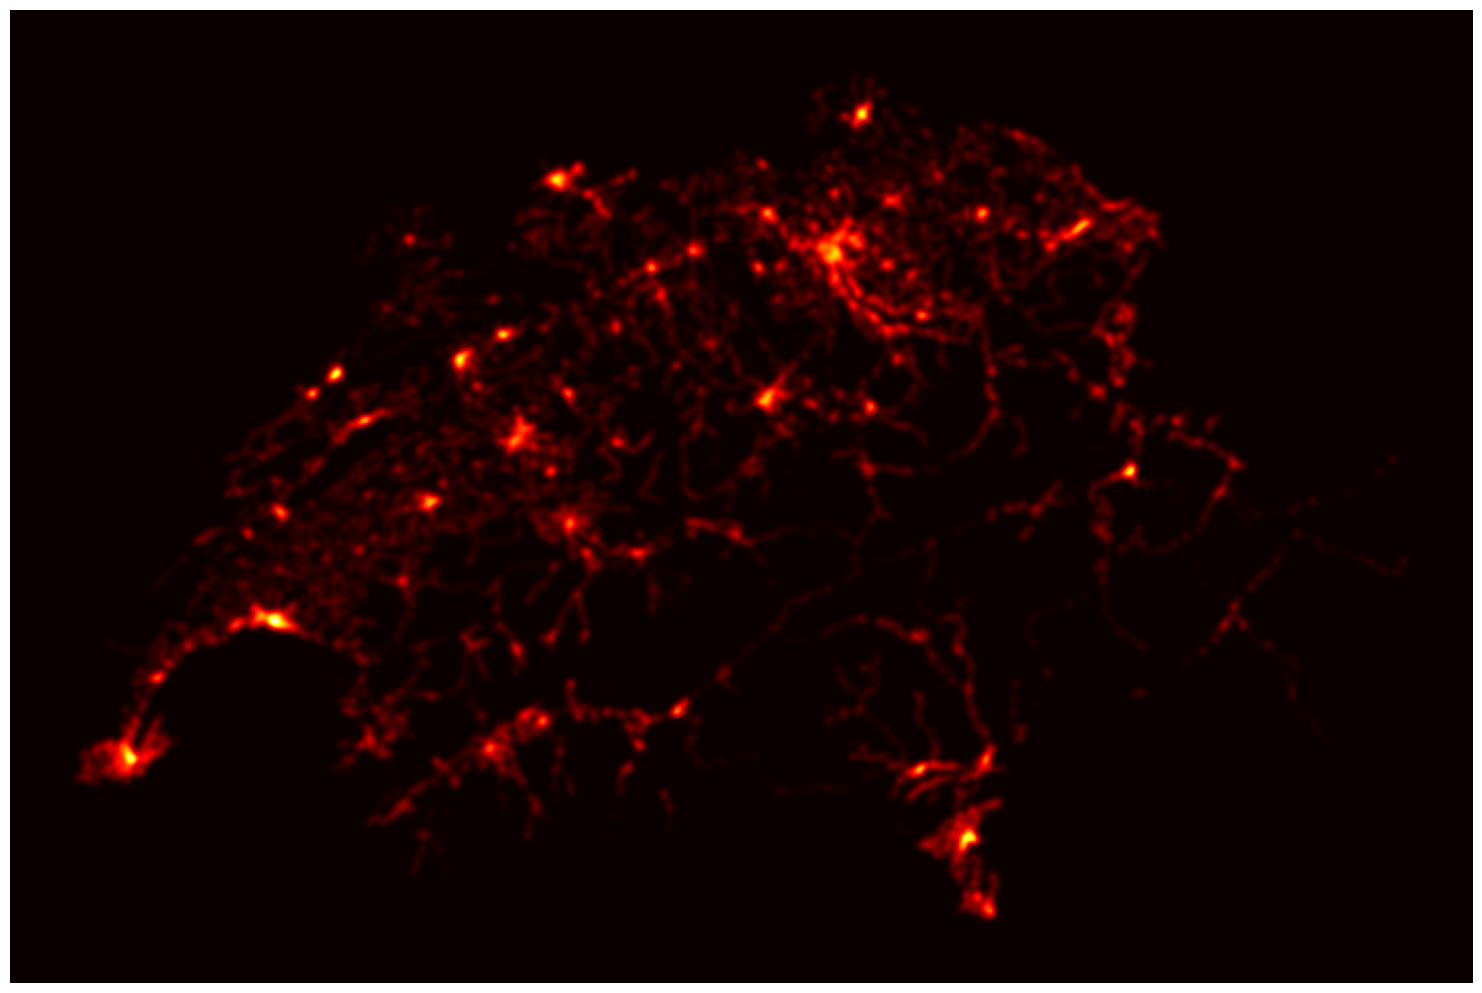

In [184]:
heatmap.show_density_heatmap(radius=5)

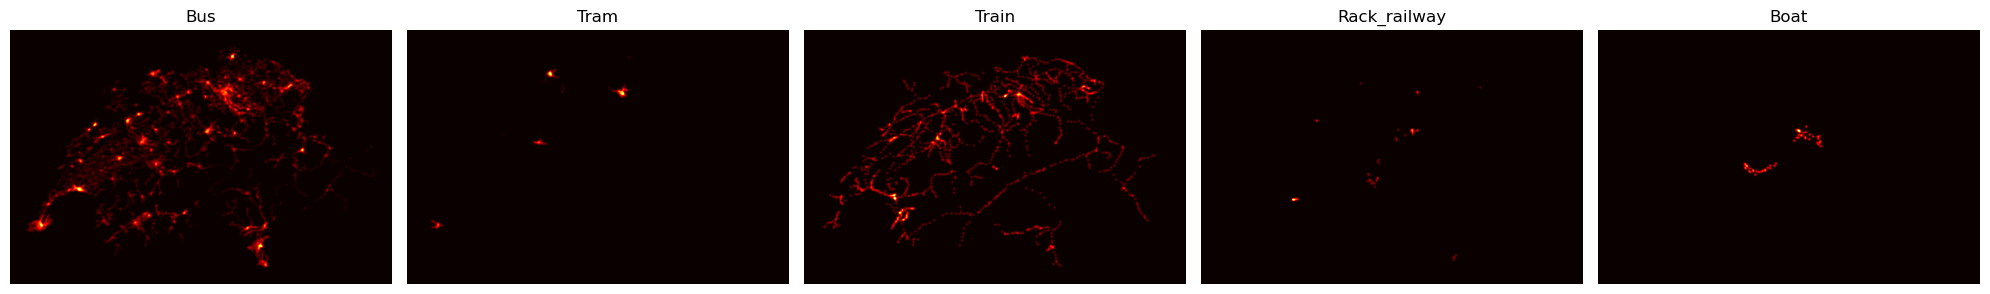

In [186]:
heatmap.show_density_heatmap_for_all_transport_types(radius=5)